In [122]:
import numpy as np
import cv2
import pywt
from matplotlib import pyplot as plt

In [123]:
wavelets = ['haar', 'db2']
dec_level = 4

### Чтение и обработка исходной картинки.

In [124]:
img = cv2.imread('src/image.jpg')
img = cv2.resize(img, (512, 512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

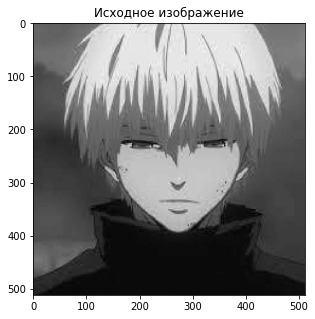

In [125]:
plt.figure(figsize=(5,5))
plt.title("Исходное изображение")
plt.imshow(img, 'gray')

### Задание 1.
Провести 4 уровня вейвлет-разложения изображения. Показать выделенные границы объекта. Удалить высокочастотные составляющие и восстановить изображение. Сравнить полученный результат с классической низкочастотной фильтрацией изображения.

##### Необходимые функции

In [126]:
def normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [127]:
def set_threshold(x, threshold):
    copy = x.copy()
    copy = normalization(copy)
    a = copy < threshold
    x[a] = np.mean(x)
    return [x, a]

In [128]:
merged_results = []
denoised_results = []
blurred_results = []

In [129]:
for wavelet in wavelets:
    # Создание списков для хранения результатов
    merged_images = []
    denoised_images = [] 
    blurred_images = []

    # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
    coeffs = pywt.wavedec2(img, wavelet, level=dec_level)

    # Удаление высокочастотных составляющих на выбранном уровне
    modified_coeffs = coeffs.copy()
    modified_coeffs = list(modified_coeffs)
    modified_coeffs[1] = tuple([set_threshold(coeff, 0.5)[0] for coeff in modified_coeffs[1]])
    modified_coeffs = tuple(modified_coeffs)
    
    approx_coeff = modified_coeffs[0].copy()
    approx_coeff = (approx_coeff - np.min(approx_coeff)) / (np.max(approx_coeff) - np.min(approx_coeff))
    merge = approx_coeff

    # Формирование детализированных компонент на каждом уровне с нормировкой
    for i in range(1, len(coeffs)):
        # Извлечение горизонтальных, вертикальных и диагональных коэффициентов
        cH, cV, cD = modified_coeffs[i]
        merge = merge[0:cH.shape[0], 0:cV.shape[1]]
        # Нормализация коэффициентов деталей
        cH, cV, cD = normalization(cH), normalization(cV), normalization(cD)
        # Слияние коэффициентов в одно изображение
        up = np.hstack((merge, cH))
        down = np.hstack((cV, cD))
        merge = np.vstack((up, down))

    merged_img = np.zeros((merge.shape[0], merge.shape[0]))
    merged_img[:, :] = merge
    merged_images.append(merged_img)

    # Классическая низкочастотная фильтрация
    denoised_img = pywt.waverec2(modified_coeffs, wavelet)
    denoised_img = np.clip(denoised_img, 0, 255).astype(np.uint8)
    
    denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))
    denoised[:, :] = denoised_img
    denoised = normalization(denoised)
    denoised_images.append(denoised)

    # Размытие исходного изображения
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
    blurred = np.zeros((blurred_img.shape[0], blurred_img.shape[0]))
    blurred[:, :] = blurred_img
    blurred = normalization(blurred)
    blurred_images.append(blurred)

    # Добавление результатов для дальнейшей отрисовки
    merged_results.append(merged_images)
    denoised_results.append(denoised_images)
    blurred_results.append(blurred_images)

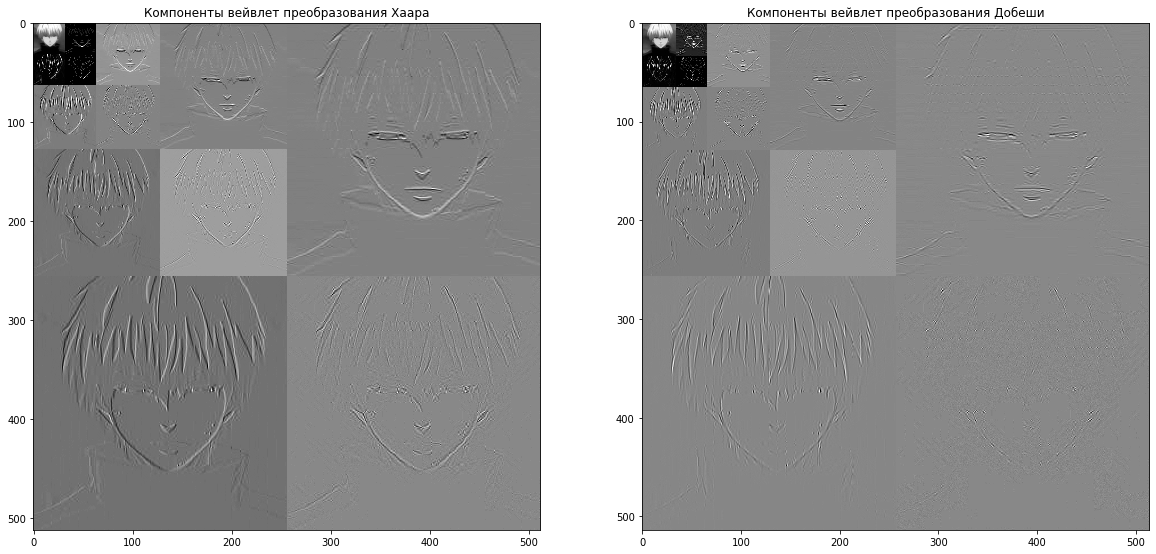

In [160]:
# Отображение компонент Вейвлет преобразований Хаара и Добеши
wawelet_haar = merged_results[0][0][:, :]
wawelet_db2 = merged_results[1][0][:, :]

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.title('Компоненты вейвлет преобразования Хаара')
plt.imshow(wawelet_haar, 'gray')

plt.subplot(1,2,2)
plt.title('Компоненты вейвлет преобразования Добеши')
plt.imshow(wawelet_db2, 'gray')

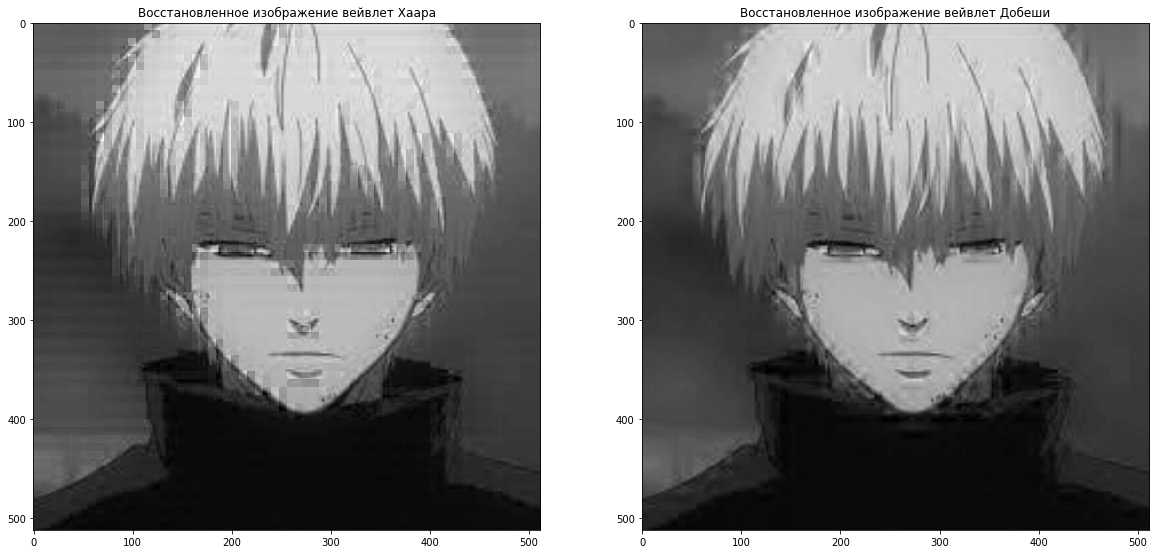

In [161]:
# Восстановленные после удаления высокочастотных составляющих изображения
wawelet_haar = denoised_results[0][0][:, :]
wawelet_db2 = denoised_results[1][0][:, :]

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.title('Восстановленное изображение вейвлет Хаара')
plt.imshow(wawelet_haar, 'gray')

plt.subplot(1,2,2)
plt.title('Восстановленное изображение вейвлет Добеши')
plt.imshow(wawelet_db2, 'gray')

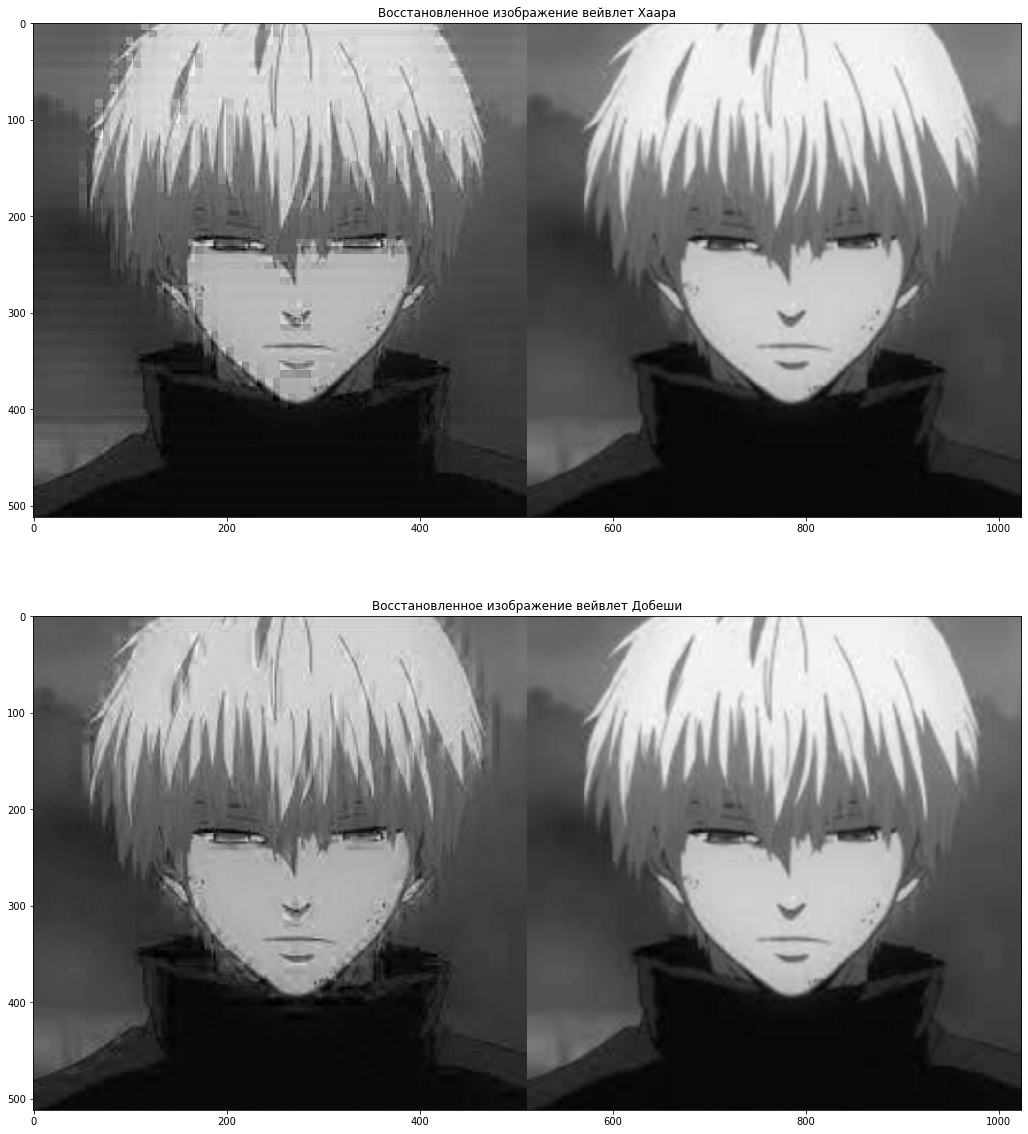

In [162]:
blur_haar = blurred_results[0][0][:, :]
blur_db2 = blurred_results[1][0][:, :]
recovery_haar = np.hstack((wawelet_haar, blur_haar))
recovery_db2 = np.hstack((wawelet_db2, blur_db2))

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title("Восстановленное изображение вейвлет Хаара")
plt.imshow(recovery_haar, 'gray')

plt.subplot(2,1,2)
plt.title("Восстановленное изображение вейвлет Добеши")
plt.imshow(recovery_db2, 'gray')

### Задание 2.
С помощью генератора случайных чисел необходимо добавить на фотографию белый гауссовский шум. Провести разложение зашумленного изображения и его фильтрацию путем применения различных уровней порога. Восстановить изображение и построить зависимость СКО восстановленного изображения от уровня порога. Представить лучший визуальный результат фильтрации изображения. Провести данный эксперимент для трех уровней шума (низкий, средний и высокий).

##### Необходимые функции

In [133]:
def normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [134]:
def set_threshold(x, threshold):
    copy = x.copy()
    copy = normalization(copy)
    x[copy < threshold] = np.mean(x)
    return x

In [135]:
def add_gaussian_noise(image, mean, stddev):
    noise = np.random.normal(mean, stddev, image.shape)
    return np.clip((image.astype(np.float32) + noise), 0, 255).astype(np.uint8)

In [136]:
# Добавление шума разного уровня
noised_img_low = add_gaussian_noise(img, 0, 5)
noised_img_mid = add_gaussian_noise(img, 0, 10)
noised_img_high = add_gaussian_noise(img, 0, 20)

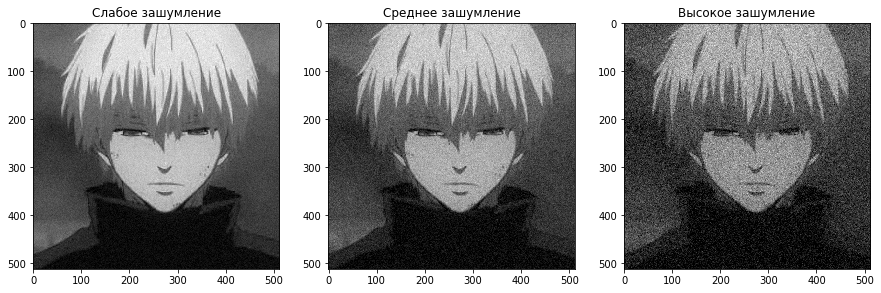

In [137]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(noised_img_low, 'gray')
axs[0].set_title('Слабое зашумление')
axs[1].imshow(noised_img_mid, 'gray')
axs[1].set_title('Среднее зашумление')
axs[2].imshow(noised_img_high, 'gray')
axs[2].set_title('Высокое зашумление')
plt.show()

In [138]:
max_threshold = 1.0
thresholds = np.linspace(0, max_threshold, 21)

In [139]:
# Вычисление значения стандартного отклонения между исходным и восстановленным изображением
def calculate_sko(image):
    # Список для хранения значений СКО
    sko_values = []
    
    for wavelet in wavelets:
        sko_wavelet = []
    
        for threshold in thresholds:
            # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
            coeffs = pywt.wavedec2(image, wavelet, level=dec_level)
            modified_coeffs = coeffs.copy()

            levels = [4]
            modified_coeffs = list(modified_coeffs)
                  
            for level in levels:
                modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

            modified_coeffs = tuple(modified_coeffs)

            # Восстановление изображения из модифицированного вейвлет-разложения
            denoised_img = pywt.waverec2(modified_coeffs, wavelet)
            denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

            # Сохранение результата восстановленного изображения
            denoised[:, :] = denoised_img
                
            denoised = normalization(denoised)
            # Расчет СКО между исходным и восстановленным изображением
            curr_sko = np.std(normalization(image) - denoised)
            # Добавление значения СКО в список для текущего вейвлета
            sko_wavelet.append(curr_sko)
        
        # Добавление списка значений СКО для текущего вейвлета в общий список
        sko_values.append(sko_wavelet)
        
    return sko_values

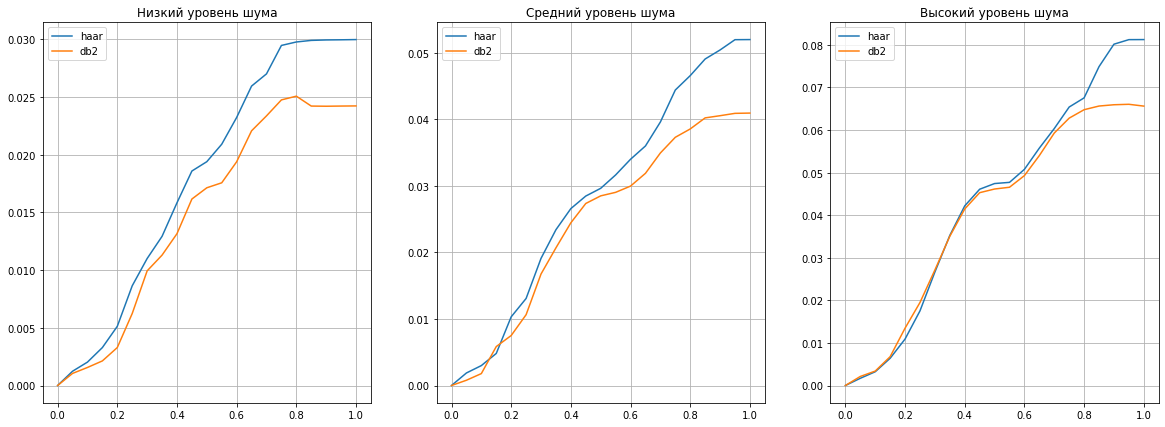

In [140]:
# Сравнение зашумленного и восстановленного
sko_low = calculate_sko(noised_img_low)
sko_mid = calculate_sko(noised_img_mid)
sko_high = calculate_sko(noised_img_high)

sko = [sko_low, sko_mid, sko_high]
title = ['Низкий', 'Средний', 'Высокий']

plt.figure(figsize=(20,7))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(thresholds, sko[i][0])
    plt.plot(thresholds, sko[i][1])
    plt.title(title[i] + ' уровень шума')
    plt.grid()
    plt.legend(wavelets)
    
plt.show()

In [141]:
# Вычисление значения стандартного отклонения между исходным незашумленным изображением и восстановленным изображением
def calculate_compare_sko(image, original_img):
    # Список для хранения значений СКО
    sko_values = []
    
    for wavelet in wavelets:
        sko_wavelet = []
    
        for threshold in thresholds:
            # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
            coeffs = pywt.wavedec2(image, wavelet, level=dec_level)
            modified_coeffs = coeffs.copy()

            levels = [4]
            modified_coeffs = list(modified_coeffs)
                  
            for level in levels:
                modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

            modified_coeffs = tuple(modified_coeffs)

            # Восстановление изображения из модифицированного вейвлет-разложения
            denoised_img = pywt.waverec2(modified_coeffs, wavelet)
            denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

            # Сохранение результата восстановленного изображения
            denoised[:, :] = denoised_img
                
            denoised = normalization(denoised)
            # Расчет СКО между исходным незашумленным и восстановленным изображением
            curr_sko = np.std(normalization(original_img) - denoised)
            # Добавление значения СКО в список для текущего вейвлета
            sko_wavelet.append(curr_sko)
        
        # Добавление списка значений СКО для текущего вейвлета в общий список
        sko_values.append(sko_wavelet)
        
    return sko_values

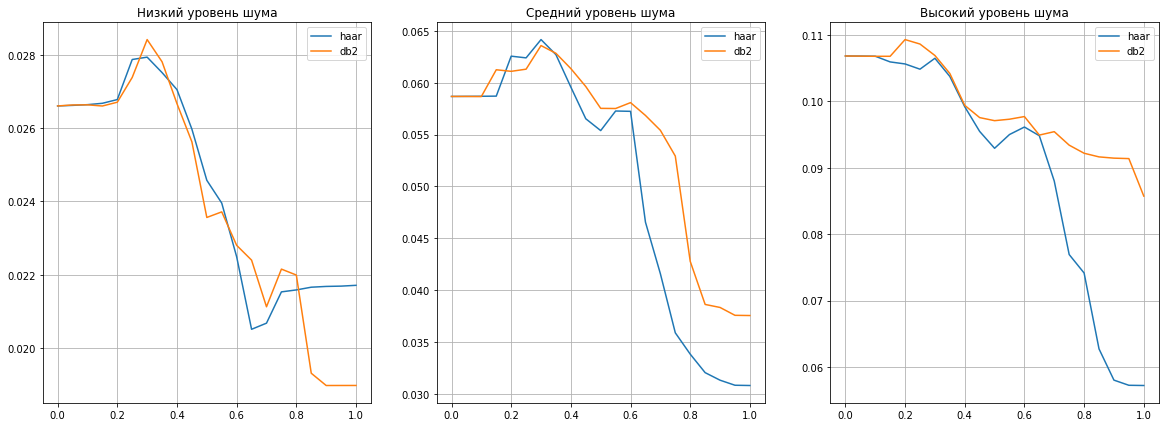

In [142]:
# Сравнение зашумленного и восстановленного
sko_low = calculate_compare_sko(noised_img_low, img)
sko_mid = calculate_compare_sko(noised_img_mid, img)
sko_high = calculate_compare_sko(noised_img_high, img)

sko = [sko_low, sko_mid, sko_high]
title = ['Низкий', 'Средний', 'Высокий']

plt.figure(figsize=(20,7))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(thresholds, sko[i][0])
    plt.plot(thresholds, sko[i][1])
    plt.title(title[i] + ' уровень шума')
    plt.grid()
    plt.legend(wavelets)
    
plt.show()

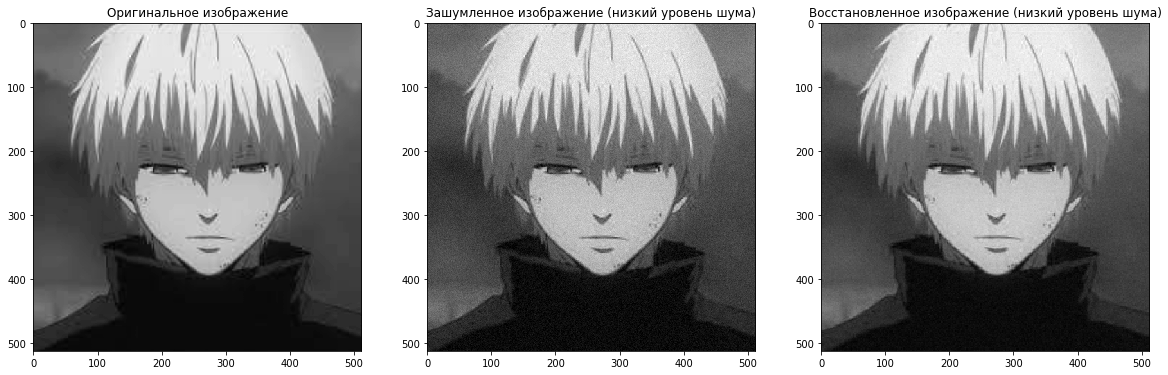

In [143]:
# Лучшая визуализация для низкого уровня шума
wavelets_low = ['haar']
thresholds_low = [1]

# Цикл по вейвлетам
for wavelet in wavelets_low:
    # Цикл по трешхолдам
    for threshold in thresholds_low:
        # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
        coeffs = pywt.wavedec2(noised_img_low, wavelet, level=dec_level)
        modified_coeffs = coeffs.copy()

        levels = [4]
        modified_coeffs = list(modified_coeffs)    

        for level in levels:
            modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])
            
        modified_coeffs = tuple(modified_coeffs)

        # Восстановление изображения из модифицированного вейвлет-разложения
        denoised_img = pywt.waverec2(modified_coeffs, wavelet)
        denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

        # Сохранение результата восстановленного изображения
        denoised[:, :] = denoised_img

        denoised = normalization(denoised)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('Оригинальное изображение')
        plt.imshow(img, 'gray')
        plt.subplot(1,3,2)
        plt.title('Зашумленное изображение (низкий уровень шума)')
        plt.imshow(noised_img_low, 'gray')
        plt.subplot(1,3,3)
        plt.title('Восстановленное изображение (низкий уровень шума)')
        plt.imshow(denoised, 'gray')
        plt.plot()

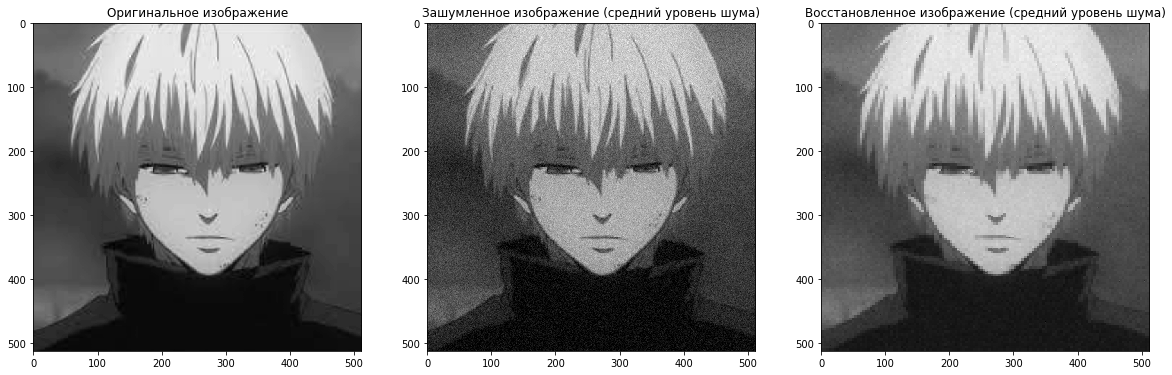

In [144]:
# Лучшая визуализация для среднего уровня шума
wavelets_mid = ['haar']
thresholds_mid = [0.9]

# Цикл по вейвлетам
for wavelet in wavelets_mid:
    # Цикл по трешхолдам
    for threshold in thresholds_mid:
        # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
        coeffs = pywt.wavedec2(noised_img_mid, wavelet, level=dec_level)
        modified_coeffs = coeffs.copy()

        levels = [3, 4]
        modified_coeffs = list(modified_coeffs)

        for level in levels:
            modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

        modified_coeffs = tuple(modified_coeffs)

        # Восстановление изображения из модифицированного вейвлет-разложения
        denoised_img = pywt.waverec2(modified_coeffs, wavelet)
        denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

        # Сохранение результата восстановленного изображения
        denoised[:, :] = denoised_img

        denoised = normalization(denoised)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('Оригинальное изображение')
        plt.imshow(img, 'gray')
        plt.subplot(1,3,2)
        plt.title('Зашумленное изображение (средний уровень шума)')
        plt.imshow(noised_img_mid, 'gray')
        plt.subplot(1,3,3)
        plt.title('Восстановленное изображение (средний уровень шума)')
        plt.imshow(denoised, 'gray')
        plt.plot()

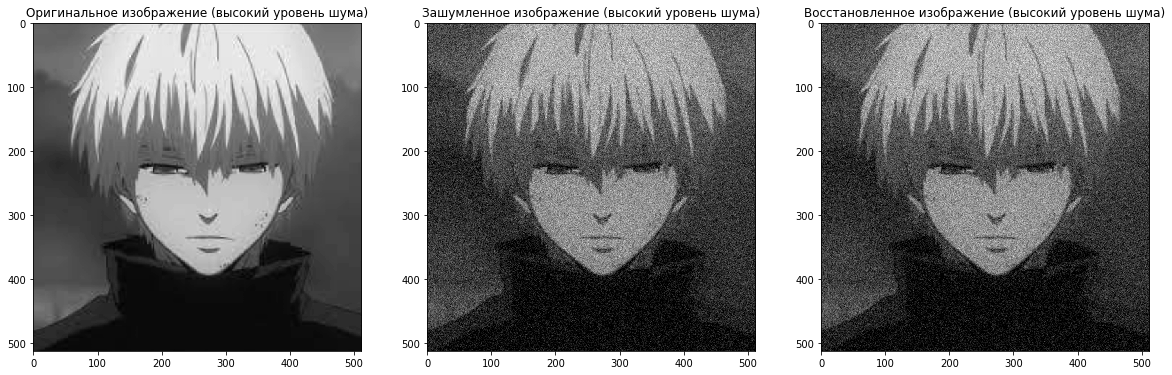

In [145]:
# Лучшая визуализация для высокого уровня шума
wavelets_high = ['haar']
thresholds = [0.2]

# Цикл по вейвлетам
for wavelet in wavelets_high:
    # Цикл по трешхолдам
    for threshold in thresholds:
        # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
        coeffs = pywt.wavedec2(noised_img_high, wavelet, level=dec_level)
        modified_coeffs = coeffs.copy()

        levels = [4]
        modified_coeffs = list(modified_coeffs)     
                   
        for level in levels:
            modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

        modified_coeffs = tuple(modified_coeffs)

        # Восстановление изображения из модифицированного вейвлет-разложения
        denoised_img = pywt.waverec2(modified_coeffs, wavelet)
        denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

        # Сохранение результата восстановленного изображения
        denoised[:, :] = denoised_img

        denoised = normalization(denoised)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('Оригинальное изображение (высокий уровень шума)')
        plt.imshow(img, 'gray')
        plt.subplot(1,3,2)
        plt.title('Зашумленное изображение (высокий уровень шума)')
        plt.imshow(noised_img_high, 'gray')
        plt.subplot(1,3,3)
        plt.title('Восстановленное изображение (высокий уровень шума)')
        plt.imshow(denoised, 'gray')
        plt.plot()

### Задание 3.
С помощью генератора случайных чисел необходимо добавить на фотографию шум типа solt and pepper. Провести разложение зашумленного изображения и его фильтрацию путем применения различных уровней порога. Восстановить изображение и построить зависимость СКО восстановленного изображения от уровня порога. Представить лучший визуальный результат фильтрации изображения. Провести данный эксперимент для трех уровней шума (низкий, средний и высокий).

##### Необходимые функции

In [146]:
def normalization(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [147]:
def set_threshold(x, threshold):
    copy = x.copy()
    copy = normalization(copy)
    x[copy > threshold] = np.mean(x)
    return x

In [148]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noised_image = image.copy()
    rows, cols = noised_image.shape
    salt_amount = int(rows * cols * salt_prob)
    pepper_amount = int(rows * cols * pepper_prob)
    
    # Добавляем salt (белые точки)
    salt_coords = [np.random.randint(0, i - 1, salt_amount) for i in noised_image.shape]
    noised_image[salt_coords[0], salt_coords[1]] = 255

    # Добавляем pepper (черные точки)
    pepper_coords = [np.random.randint(0, i - 1, pepper_amount) for i in noised_image.shape]
    noised_image[pepper_coords[0], pepper_coords[1]] = 0
    
    return noised_image

In [149]:
# Добавление шума разного уровня
noised_img_low = add_salt_and_pepper_noise(img, 0.005, 0.005)
noised_img_mid = add_salt_and_pepper_noise(img, 0.015, 0.015)
noised_img_high = add_salt_and_pepper_noise(img, 0.03, 0.03)

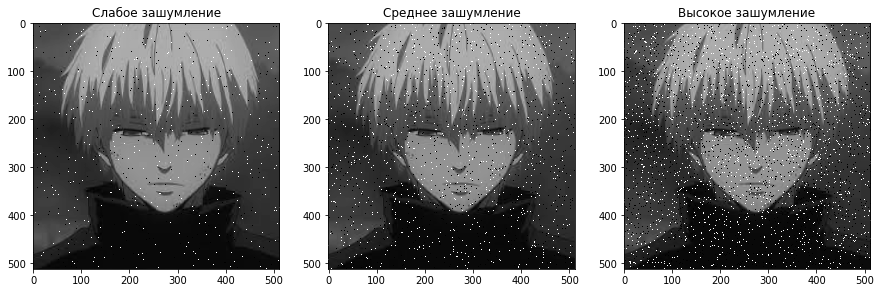

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs[0].imshow(noised_img_low, 'gray')
axs[0].set_title('Слабое зашумление')
axs[1].imshow(noised_img_mid, 'gray')
axs[1].set_title('Среднее зашумление')
axs[2].imshow(noised_img_high, 'gray')
axs[2].set_title('Высокое зашумление')
plt.show()

In [151]:
max_threshold = 1.0
thresholds = np.linspace(0, max_threshold, 21)

In [152]:
# Вычисление значения стандартного отклонения между исходным и восстановленным изображением
def calculate_sko(image):
    # Список для хранения значений СКО
    sko_values = []
    
    for wavelet in wavelets:
        sko_wavelet = []
    
        for threshold in thresholds:
            # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
            coeffs = pywt.wavedec2(image, wavelet, level=dec_level)
            modified_coeffs = coeffs.copy()

            levels = [4]
            modified_coeffs = list(modified_coeffs)
                  
            for level in levels:
                modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

            modified_coeffs = tuple(modified_coeffs)

            # Восстановление изображения из модифицированного вейвлет-разложения
            denoised_img = pywt.waverec2(modified_coeffs, wavelet)
            denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

            # Сохранение результата восстановленного изображения
            denoised[:, :] = denoised_img
                
            denoised = normalization(denoised)
            # Расчет СКО между исходным и восстановленным изображением
            curr_sko = np.std(normalization(image) - denoised)
            # Добавление значения СКО в список для текущего вейвлета
            sko_wavelet.append(curr_sko)
        
        # Добавление списка значений СКО для текущего вейвлета в общий список
        sko_values.append(sko_wavelet)
        
    return sko_values

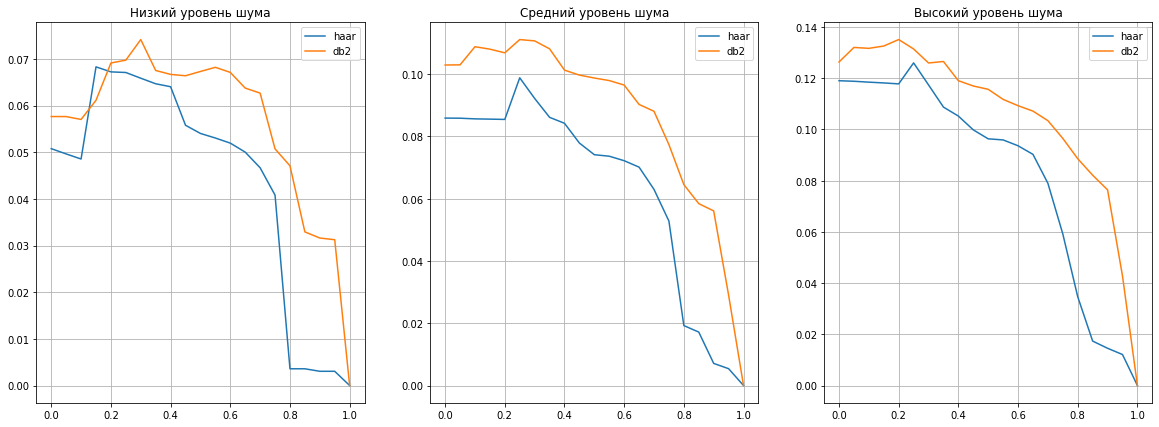

In [153]:
# Сравнение зашумленного и восстановленного
sko_low = calculate_sko(noised_img_low)
sko_mid = calculate_sko(noised_img_mid)
sko_high = calculate_sko(noised_img_high)

sko = [sko_low, sko_mid, sko_high]
title = ['Низкий', 'Средний', 'Высокий']

plt.figure(figsize=(20,7))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(thresholds, sko[i][0])
    plt.plot(thresholds, sko[i][1])
    plt.title(title[i] + ' уровень шума')
    plt.grid()
    plt.legend(wavelets)
    
plt.show()

In [154]:
# Вычисление значения стандартного отклонения между исходным незашумленным изображением и восстановленным изображением
def calculate_compare_sko(image, original_img):
    # Список для хранения значений СКО
    sko_values = []
    
    for wavelet in wavelets:
        sko_wavelet = []
    
        for threshold in thresholds:
            # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
            coeffs = pywt.wavedec2(image, wavelet, level=dec_level)
            modified_coeffs = coeffs.copy()

            levels = [4]
            modified_coeffs = list(modified_coeffs)
                  
            for level in levels:
                modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

            modified_coeffs = tuple(modified_coeffs)

            # Восстановление изображения из модифицированного вейвлет-разложения
            denoised_img = pywt.waverec2(modified_coeffs, wavelet)
            denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

            # Сохранение результата восстановленного изображения
            denoised[:, :] = denoised_img
                
            denoised = normalization(denoised)
            # Расчет СКО между исходным незашумленным и восстановленным изображением
            curr_sko = np.std(normalization(original_img) - denoised)
            # Добавление значения СКО в список для текущего вейвлета
            sko_wavelet.append(curr_sko)
        
        # Добавление списка значений СКО для текущего вейвлета в общий список
        sko_values.append(sko_wavelet)
        
    return sko_values

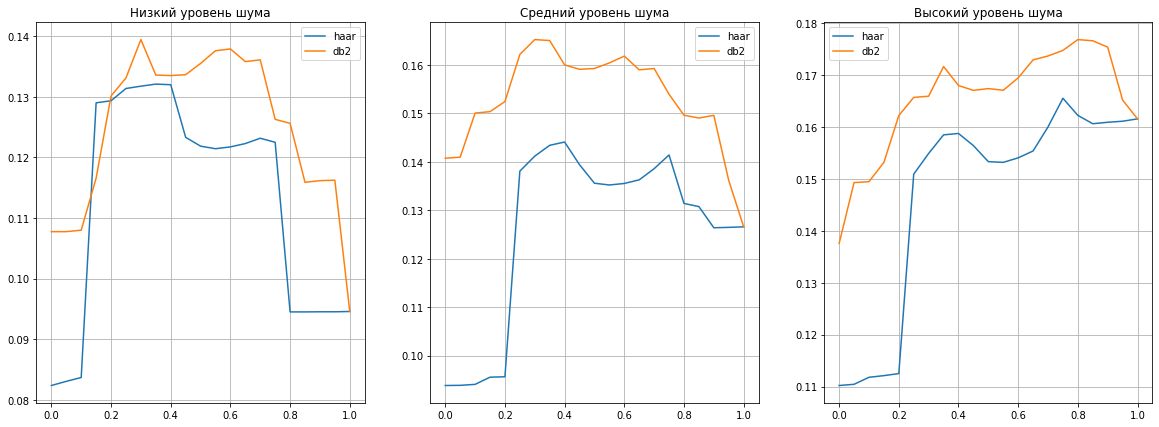

In [155]:
# Сравнение зашумленного и восстановленного
sko_low = calculate_compare_sko(noised_img_low, img)
sko_mid = calculate_compare_sko(noised_img_mid, img)
sko_high = calculate_compare_sko(noised_img_high, img)

sko = [sko_low, sko_mid, sko_high]
title = ['Низкий', 'Средний', 'Высокий']

plt.figure(figsize=(20,7))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(thresholds, sko[i][0])
    plt.plot(thresholds, sko[i][1])
    plt.title(title[i] + ' уровень шума')
    plt.grid()
    plt.legend(wavelets)
    
plt.show()

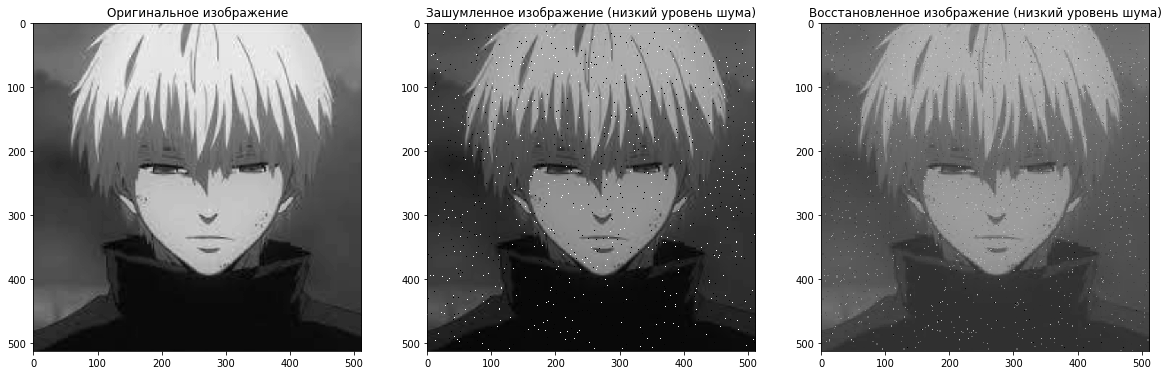

In [156]:
# Лучшая визуализация для низкого уровня шума
wavelets_low = ['haar']
thresholds_low = [0.15]

# Цикл по вейвлетам
for wavelet in wavelets_low:
    # Цикл по трешхолдам
    for threshold in thresholds_low:
        # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
        coeffs = pywt.wavedec2(noised_img_low, wavelet, level=dec_level)
        modified_coeffs = coeffs.copy()

        levels = [4]
        modified_coeffs = list(modified_coeffs)    

        for level in levels:
            modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])
            
        modified_coeffs = tuple(modified_coeffs)

        # Восстановление изображения из модифицированного вейвлет-разложения
        denoised_img = pywt.waverec2(modified_coeffs, wavelet)
        denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

        # Сохранение результата восстановленного изображения
        denoised[:, :] = denoised_img

        denoised = normalization(denoised)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('Оригинальное изображение')
        plt.imshow(img, 'gray')
        plt.subplot(1,3,2)
        plt.title('Зашумленное изображение (низкий уровень шума)')
        plt.imshow(noised_img_low, 'gray')
        plt.subplot(1,3,3)
        plt.title('Восстановленное изображение (низкий уровень шума)')
        plt.imshow(denoised, 'gray')
        plt.plot()

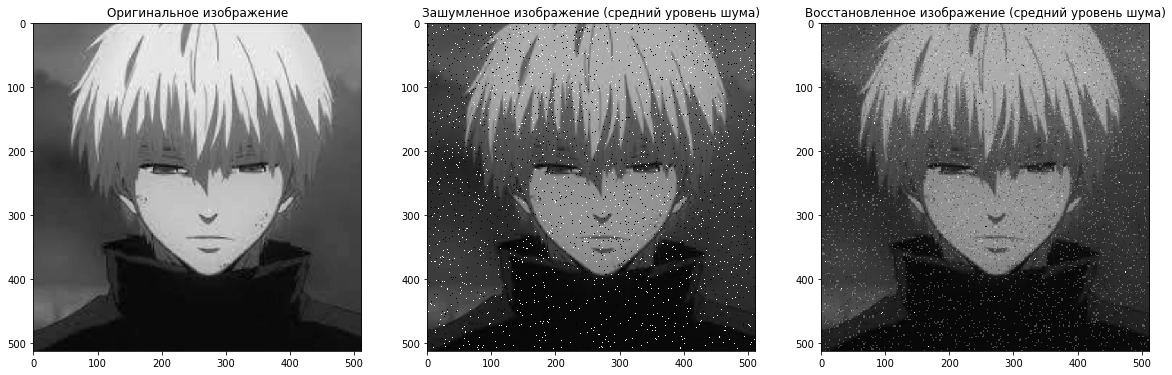

In [157]:
# Лучшая визуализация для среднего уровня шума
wavelets_mid = ['haar']
thresholds_mid = [0.2]

# Цикл по вейвлетам
for wavelet in wavelets_mid:
    # Цикл по трешхолдам
    for threshold in thresholds_mid:
        # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
        coeffs = pywt.wavedec2(noised_img_mid, wavelet, level=dec_level)
        modified_coeffs = coeffs.copy()

        levels = [4]
        modified_coeffs = list(modified_coeffs)

        for level in levels:
            modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

        modified_coeffs = tuple(modified_coeffs)

        # Восстановление изображения из модифицированного вейвлет-разложения
        denoised_img = pywt.waverec2(modified_coeffs, wavelet)
        denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

        # Сохранение результата восстановленного изображения
        denoised[:, :] = denoised_img

        denoised = normalization(denoised)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('Оригинальное изображение')
        plt.imshow(img, 'gray')
        plt.subplot(1,3,2)
        plt.title('Зашумленное изображение (средний уровень шума)')
        plt.imshow(noised_img_mid, 'gray')
        plt.subplot(1,3,3)
        plt.title('Восстановленное изображение (средний уровень шума)')
        plt.imshow(denoised, 'gray')
        plt.plot()

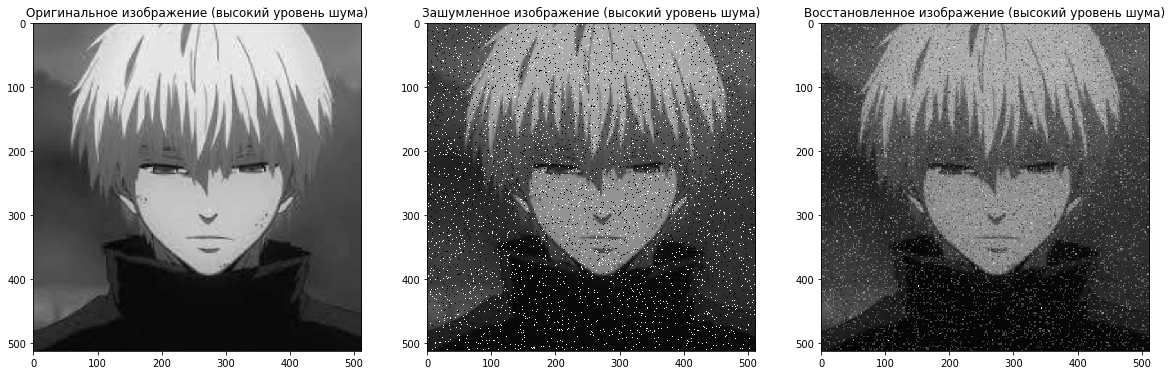

In [158]:
# Лучшая визуализация для высокого уровня шума
wavelets_high = ['haar']
thresholds = [0]

# Цикл по вейвлетам
for wavelet in wavelets_high:
    # Цикл по трешхолдам
    for threshold in thresholds:
        # Выполнение 4-уровневого вейвлет-разложения с помощью выбранного вейвлета
        coeffs = pywt.wavedec2(noised_img_high, wavelet, level=dec_level)
        modified_coeffs = coeffs.copy()

        levels = [4]
        modified_coeffs = list(modified_coeffs)     
                   
        for level in levels:
            modified_coeffs[level] = tuple([set_threshold(modified_coeffs[level][i], threshold) for i in range(3)])

        modified_coeffs = tuple(modified_coeffs)

        # Восстановление изображения из модифицированного вейвлет-разложения
        denoised_img = pywt.waverec2(modified_coeffs, wavelet)
        denoised = np.zeros((denoised_img.shape[0], denoised_img.shape[0]))

        # Сохранение результата восстановленного изображения
        denoised[:, :] = denoised_img

        denoised = normalization(denoised)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.title('Оригинальное изображение (высокий уровень шума)')
        plt.imshow(img, 'gray')
        plt.subplot(1,3,2)
        plt.title('Зашумленное изображение (высокий уровень шума)')
        plt.imshow(noised_img_high, 'gray')
        plt.subplot(1,3,3)
        plt.title('Восстановленное изображение (высокий уровень шума)')
        plt.imshow(denoised, 'gray')
        plt.plot()